In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df=pd.read_csv('data.csv',parse_dates=True,index_col='DATE')
df.columns=['Sales']
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


<AxesSubplot:xlabel='DATE'>

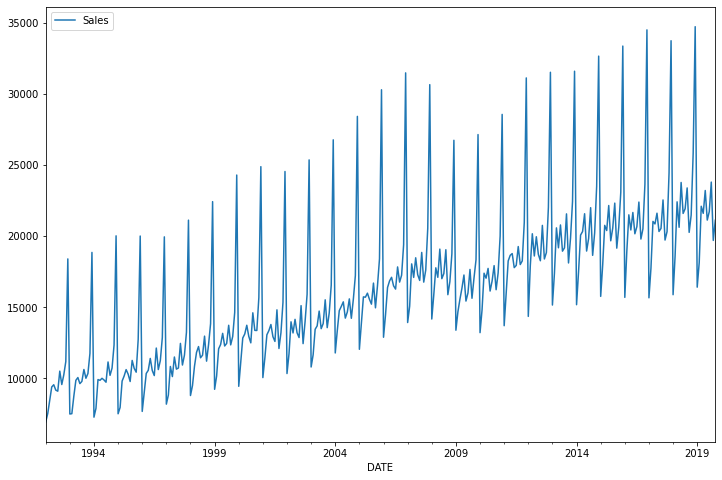

In [3]:
df.plot(figsize=(12,8))

In [4]:
#total dataframe length
len(df)

334

In [5]:
#Data is monthly, let's forecast 1.5 years into the future.
len(df)-18

316

In [6]:
test_size = 18
test_ind = len(df)- test_size

In [7]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
train.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [10]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [11]:
# What does the first batch look like?
X,y = generator[0]

In [12]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SimpleRNN

In [14]:
# We're only using one feature in our time series
n_features = 1
# define model
model = Sequential()

# Simple RNN layer
model.add(SimpleRNN(100,input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               10200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


C:\Users\Henry\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


304/304 [==============================] - 2s 5ms/step - loss: 0.0338 - val_loss: 0.0053
Epoch 2/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0025 - val_loss: 0.0055
Epoch 3/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 4/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 5/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0074 - val_loss: 0.0016
Epoch 6/20
304/304 [==============================] - 1s 4ms/step - loss: 0.0033 - val_loss: 0.0105


<AxesSubplot:>

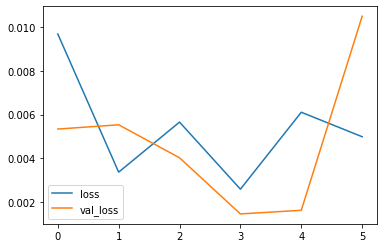

In [17]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [18]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [19]:
true_predictions = scaler.inverse_transform(test_predictions)

In [20]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [21]:
test.head()

,Sales,Predictions
DATE,,
2018-05-01,23764,23759.339463
2018-06-01,21589,21924.745849
2018-07-01,21919,22486.298343
2018-08-01,23381,24849.286018
2018-09-01,20260,24233.902173


<AxesSubplot:xlabel='DATE'>

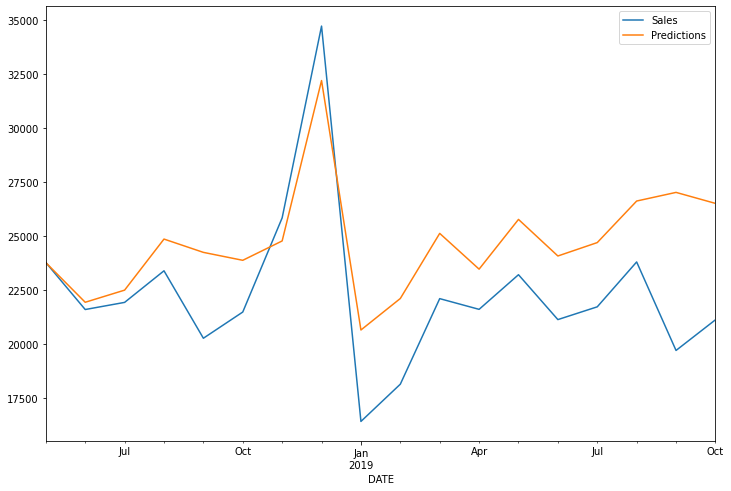

In [22]:
test.plot(figsize=(12,8))

In [23]:
#Using LSTM

In [24]:
#model
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [25]:
# We're only using one feature in our time series
n_features = 1

In [26]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [29]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [30]:
# fit model
model.fit_generator(generator, epochs =20, validation_data = validation_generator,callbacks =[early_stop])

C:\Users\Henry\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
304/304 [==============================] - 3s 7ms/step - loss: 0.0363 - val_loss: 0.0029
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0187 - val_loss: 0.0025
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0168 - val_loss: 0.0015
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0110 - val_loss: 6.1626e-04
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0046 - val_loss: 0.0154
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0077 - val_loss: 3.3226e-04
Epoch 7/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 8/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0022 - val_loss: 2.3418e-04
Epoch 9/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 10/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0021 - val_

In [31]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

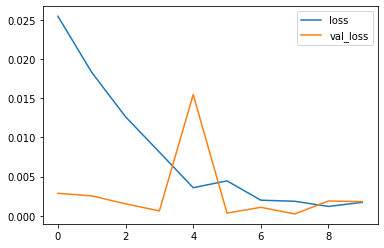

In [32]:
losses.plot()

In [33]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [34]:
true_predictions = scaler.inverse_transform(test_predictions)

In [35]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

C:\Users\Henry\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [36]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,22321.683320
2018-06-01,21589,21047.745804
2018-07-01,21919,21274.487943
2018-08-01,23381,23311.440420
2018-09-01,20260,20509.719593
2018-10-01,21473,21204.700420
2018-11-01,25831,25520.121623
2018-12-01,34706,35432.914928
2019-01-01,16410,16253.929225


<AxesSubplot:xlabel='DATE'>

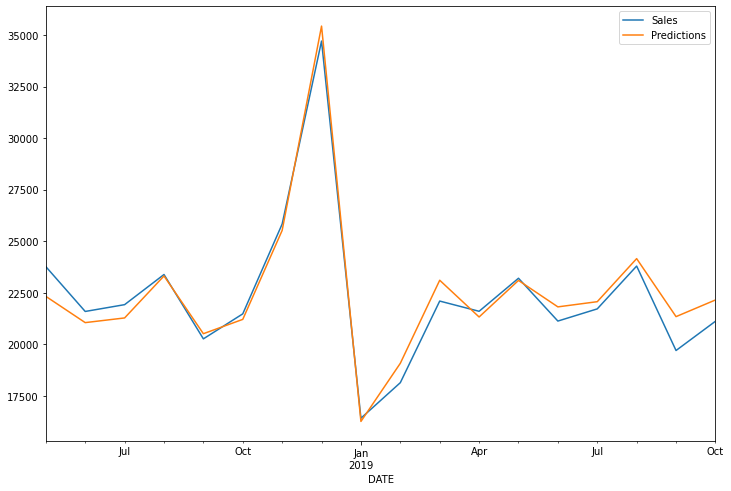

In [37]:
test.plot(figsize=(12,8))

In [38]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [39]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [40]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)


C:\Users\Henry\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/8
322/322 [==============================] - 3s 6ms/step - loss: 0.0352
Epoch 2/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0170
Epoch 3/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0109
Epoch 4/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0043
Epoch 5/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0029
Epoch 6/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0023
Epoch 7/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0014
Epoch 8/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0016


In [42]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [43]:
forecast = scaler.inverse_transform(forecast)

In [45]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [46]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [47]:
forecast_df

,Forecast
2019-11-01,24950.140383
2019-12-01,33593.440391
2020-01-01,16486.173690
2020-02-01,18083.517962
2020-03-01,21311.246733
2020-04-01,21008.310961
2020-05-01,22385.419352
2020-06-01,20731.014404
2020-07-01,21242.557541
2020-08-01,22903.444118


<AxesSubplot:>

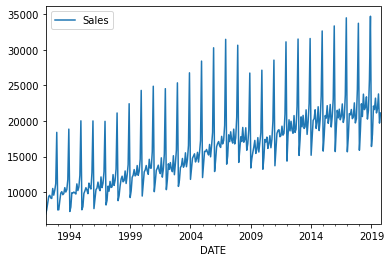

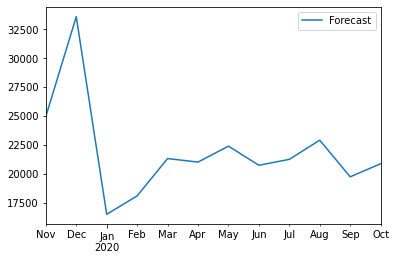

In [48]:
df.plot()
forecast_df.plot()

<AxesSubplot:xlabel='DATE'>

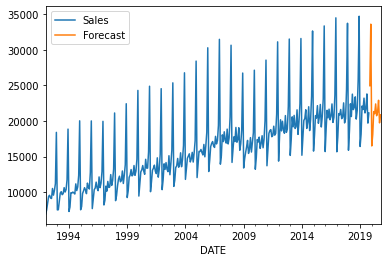

In [49]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576.0, 611.0)

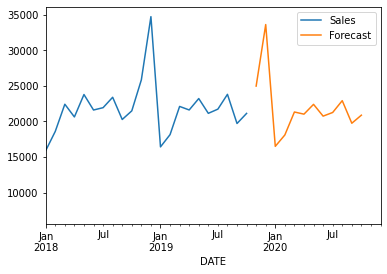

In [50]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')